In [1]:
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import cross_val_predict, cross_val_predict, train_test_split
from sklearn.metrics import (roc_auc_score, confusion_matrix, precision_score, f1_score,
                             recall_score, roc_curve, precision_recall_curve, auc)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA

from utils import plot_confusion_matrix

In [2]:
dir_path = 'FEATURES-2014-2015/'
names_list = os.listdir(dir_path)[::4]
sequences = pd.concat([pd.read_csv(dir_path + name) for name in names_list])

In [3]:
labels = sequences['isAnomaly']
sequences = sequences.drop(columns=['isAnomaly', 'host', 'process', 'timestamp'])

In [7]:
pca = PCA(n_components=2)
pca_sequences = pca.fit_transform(sequences)

In [10]:
pca.explained_variance_ratio_

array([9.99947315e-01, 5.26810771e-05])

In [11]:
pca.explained_variance_ratio_.cumsum()

array([0.99994732, 1.        ])

In [24]:
rand_idxes = np.random.randint(low=0, high=len(pca_sequences), size=1000)

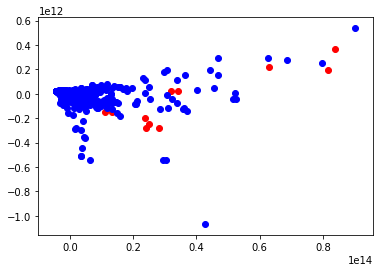

In [34]:
plt.scatter(pca_sequences[rand_idxes, 0][labels.iloc[rand_idxes]], 
            pca_sequences[rand_idxes, 1][labels.iloc[rand_idxes]], c='r')

plt.scatter(pca_sequences[rand_idxes, 0][~labels.iloc[rand_idxes]], 
            pca_sequences[rand_idxes, 1][~labels.iloc[rand_idxes]], c='b')

In [53]:
pca = PCA(n_components=1)
pca_sequences = pca.fit_transform(sequences).squeeze()

In [66]:
pca_sequences[labels].shape

(46117,)

In [63]:
np.median(pca_sequences[labels])

6057714867324.881

In [67]:
pca_sequences[~labels].shape

(1869496,)

In [64]:
np.median(pca_sequences[~labels])

-3217056746517.788

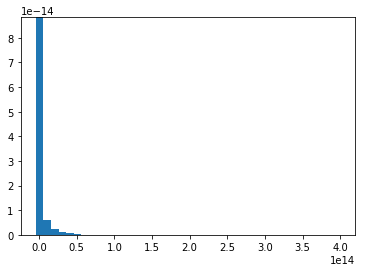

In [49]:
plt.hist(pca_sequences, bins=40, density=True);

In [7]:
isolation = IsolationForest(behaviour='new')
isolation_labels = isolation.fit_predict(sequences)

/home/eugene/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [9]:
isolation_labels[isolation_labels == 1] = False
isolation_labels[isolation_labels == -1] = True

0.33544246013061035

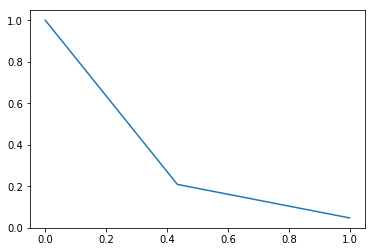

In [11]:
pr, rc, _ = precision_recall_curve(labels, isolation_labels)
plt.plot(rc, pr)
auc(rc, pr)

In [13]:
roc_auc_score(labels, isolation_labels)

0.6754441124147068

In [14]:
f1_score(labels, isolation_labels)

0.28266984678968404

In [ ]:
density = KernelDensity()
density.fit(sequences)

In [4]:
%%time
forest = RandomForestClassifier(n_estimators=40, n_jobs=-1)
forest_labels = cross_val_predict(forest, sequences, labels, cv=4,
                                  method='predict_proba')[:, 1]

CPU times: user 16.3 s, sys: 10.4 s, total: 26.7 s
Wall time: 49.7 s


In [6]:
%%time
boosting = LGBMClassifier(max_depth=7, n_estimators=80, n_jobs=-1)
boosting_labels = cross_val_predict(boosting, sequences, labels, cv=4,
                                    method='predict_proba')[:, 1]

CPU times: user 5min 30s, sys: 15.1 s, total: 5min 46s
Wall time: 54.4 s


In [4]:
%%time
scaler = StandardScaler(copy=False)
logreg = LogisticRegression(solver='lbfgs', n_jobs=1)
logreg_pipe = Pipeline([('scaler', scaler), ('logreg', logreg)])
logreg_labels = cross_val_predict(logreg_pipe, sequences, labels,
                                  cv=4, method='predict_proba')[:, 1]

CPU times: user 1.99 s, sys: 1.11 s, total: 3.11 s
Wall time: 1min 19s


In [ ]:
%%time
network = MLPClassifier(layers=[256], loss='log_loss', epochs=40)
network.fit(sequences, labels)

In [ ]:
%%time
network = MLPClassifier(layers=[256], loss='log_loss', epochs=40)
network_labels = cross_val_predict(network, sequences, labels, cv=4,
                                    method='predict_proba')[:, 1]

# Experiments

In [27]:
q = 0.2 # type II errors
n = 5 # window
1 - q**n # Probability of anomaly detection

0.99968

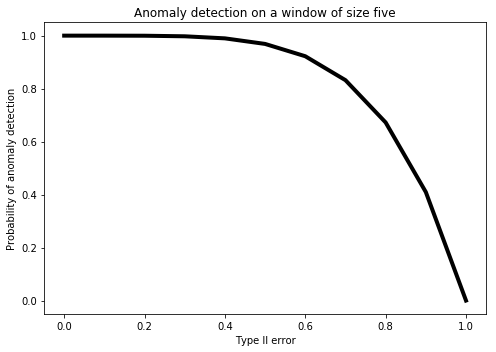

In [37]:
q = np.arange(0, 1.1, 0.1)
plt.figure(0, (7, 5))
plt.title('Anomaly detection on a window of size five')
plt.plot(q, 1 - q**n, lw=4, c='k')
plt.ylabel('Probability of anomaly detection')
plt.xlabel('Type II error')
plt.tight_layout()

In [39]:
for i in np.arange(0, 0.2, 0.01):
    print('threshold:', i)
    x = confusion_matrix(labels, forest_labels > i).astype(float)
    x /= x.sum(axis=1)[:, None]
    print(x)

threshold: 0.0
[[0.69112618 0.30887382]
 [0.15742212 0.84257788]]
threshold: 0.01
[[0.69112618 0.30887382]
 [0.15742212 0.84257788]]
threshold: 0.02
[[0.69112618 0.30887382]
 [0.15742212 0.84257788]]
threshold: 0.03
[[0.7850179  0.2149821 ]
 [0.28983895 0.71016105]]
threshold: 0.04
[[0.7850179  0.2149821 ]
 [0.28983895 0.71016105]]
threshold: 0.05
[[0.8257931  0.1742069 ]
 [0.34146535 0.65853465]]
threshold: 0.06
[[0.8257931  0.1742069 ]
 [0.34146535 0.65853465]]
threshold: 0.07
[[0.8257931  0.1742069 ]
 [0.34146535 0.65853465]]
threshold: 0.08
[[0.85714877 0.14285123]
 [0.38172812 0.61827188]]
threshold: 0.09
[[0.85714877 0.14285123]
 [0.38172812 0.61827188]]
threshold: 0.1
[[0.87118492 0.12881508]
 [0.40604471 0.59395529]]
threshold: 0.11
[[0.87118492 0.12881508]
 [0.40604471 0.59395529]]
threshold: 0.12
[[0.87118492 0.12881508]
 [0.40604471 0.59395529]]
threshold: 0.13
[[0.87797388 0.12202612]
 [0.42003073 0.57996927]]
threshold: 0.14
[[0.87797388 0.12202612]
 [0.42003073 0.57996927

In [7]:
precision_score(labels, network_labels > 0.5), recall_score(labels, network_labels > 0.5)

(0.1181587032140357, 0.8628946810764992)

In [8]:
roc_auc_score(labels, network_labels)

0.849866949356083

Text(0, 0.5, 'TPR')

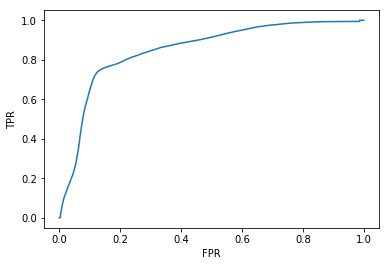

In [9]:
fpr, tpr, _ = roc_curve(labels, network_labels)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

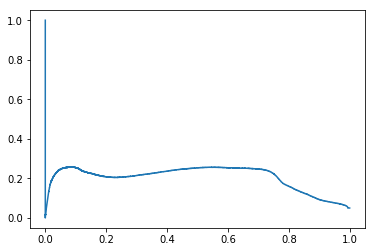

In [14]:
pr, rc, _ = precision_recall_curve(labels, network_labels)
plt.plot(rc, pr)

Normalized confusion matrix
[[0.66 0.34]
 [0.14 0.86]]


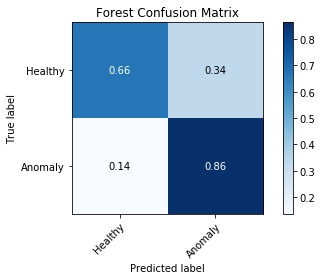

In [24]:
class_names = np.array(["Healthy", "Anomaly"])
np.set_printoptions(precision=2)
plot_confusion_matrix(labels.astype(int), network_labels > 0.5,
    classes=class_names, normalize=True, title="Forest Confusion Matrix")